In [1]:
%matplotlib inline
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from collections import deque
from IPython.display import display
from JSAnimation.IPython_display import display_animation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import animation
from scipy import stats

Using TensorFlow backend.


In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.9                 # discount rate
        self.epsilon = 1.0               # exploration rate
        self.e_decay = .9995             # exploration rate decay
        self.e_min = 0.05                # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model (Adam optimizer)
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_size, activation='relu'))
        model.add(Dense(20, activation='relu', kernel_initializer='uniform'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_model))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        return self.act_greedy(state)
    
    def act_greedy(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = np.zeros((batch_size, self.state_size))
        Y = np.zeros((batch_size, self.action_size))
        for i in range(batch_size):
            state, action, reward, next_state, done = minibatch[i]
            target = self.model.predict(state)[0]
            if done:
                target[action] = 0
            else:
                target[action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
#                 target[action] = target[action] + self.learning_rate * \
#                     (reward + self.gamma * np.amax(self.model.predict(next_state)[0] - target[action]))
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [4]:
def train(env):
    EPISODES = 4000
    
    # When agent see done=True we put a penalty, but also, done equals True in the last episode
    FRAMES_PER_EPISODE = min(1000, env.spec.max_episode_steps - 1)

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    for e in range(1, EPISODES + 1):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        times = []
        for time in range(FRAMES_PER_EPISODE):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done or time == FRAMES_PER_EPISODE - 1:
                times.append(time)
                if e % (EPISODES / 20) == 0:
                    print("episode: {}/{}, avg time: {}, exploration rate: {:.2}"
                          .format(e, EPISODES, np.average(times), agent.epsilon))
                break
        agent.replay(32)
        
    return agent

In [5]:
def evaluate(env, agent, play_count, render):
    FRAMES = min(500, env.spec.max_episode_steps)

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    times = []
    rewards = []
    
    for t in range(play_count):
        state = env.reset()
        frames = []
        for e in range(FRAMES):
            if render:
                frames.append(env.render(mode = 'rgb_array'))
            state = np.reshape(state, [1, state_size])
            action = agent.act_greedy(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done or e == FRAMES - 1:
                times.append(e)
                break

        if render:
            env.render(close=True)
            display_frames_as_gif(frames)
            render = False
            
    return times, rewards

In [6]:
env.render(close=True)

NameError: name 'env' is not defined

In [7]:
env = gym.make('CartPole-v0')
env.seed(1337)
agent = train(env)

[2017-05-25 14:41:19,700] Making new env: CartPole-v0


episode: 200/4000, avg time: 19.0, exploration rate: 0.91
episode: 400/4000, avg time: 22.0, exploration rate: 0.82
episode: 600/4000, avg time: 25.0, exploration rate: 0.74
episode: 800/4000, avg time: 35.0, exploration rate: 0.67
episode: 1000/4000, avg time: 33.0, exploration rate: 0.61
episode: 1200/4000, avg time: 139.0, exploration rate: 0.55
episode: 1400/4000, avg time: 158.0, exploration rate: 0.5
episode: 1600/4000, avg time: 27.0, exploration rate: 0.45
episode: 1800/4000, avg time: 119.0, exploration rate: 0.41
episode: 2000/4000, avg time: 25.0, exploration rate: 0.37
episode: 2200/4000, avg time: 177.0, exploration rate: 0.33
episode: 2400/4000, avg time: 115.0, exploration rate: 0.3
episode: 2600/4000, avg time: 198.0, exploration rate: 0.27
episode: 2800/4000, avg time: 198.0, exploration rate: 0.25
episode: 3000/4000, avg time: 26.0, exploration rate: 0.22
episode: 3200/4000, avg time: 97.0, exploration rate: 0.2
episode: 3400/4000, avg time: 198.0, exploration rate: 0

DescribeResult(nobs=100, minmax=(102, 127), mean=112.29000000000001, variance=41.985757575757575, skewness=0.40675582009808675, kurtosis=-0.5143571165535552)


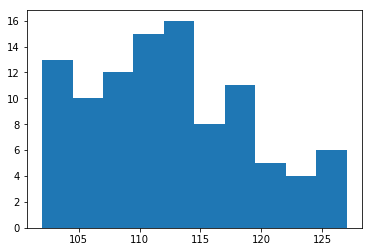

In [8]:
times, rewards = evaluate(env, agent, 100, False)
plt.hist(times)
print(stats.describe(times))

# plt.hist(rewards)
# print(stats.describe(rewards))

In [9]:
print(agent.memory[0])
print(agent.model.predict(agent.memory[0][0]))

(array([[ 1.94731386,  2.17334672,  0.12232983,  0.01602223]]), 0, 1.0, array([[ 1.9907808 ,  1.97670211,  0.12265027,  0.3446602 ]]), False)
[[ 7.11011839  6.8039546 ]]
